## Importing the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the Dataset

In [ ]:
import os
folder_path = '/kaggle/input/eye-diseases-classification/dataset'


cataract = Path(folder_path+'/cataract')
normal = Path(folder_path+'/normal')


In [ ]:
from tqdm import tqdm

disease_type = [cataract,normal]
#                  0          1
df = pd.DataFrame()
 # build the dataframe
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/kaggle/input/eye-diseases-classification/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1385.71it/s]
/kaggle/input/eye-diseases-classification/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1840.28it/s]


In [ ]:
df

,image,disease_type
0,/kaggle/input/eye-diseases-classification/data...,0
1,/kaggle/input/eye-diseases-classification/data...,0
2,/kaggle/input/eye-diseases-classification/data...,0
3,/kaggle/input/eye-diseases-classification/data...,0
4,/kaggle/input/eye-diseases-classification/data...,0
...,...,...
2107,/kaggle/input/eye-diseases-classification/data...,1
2108,/kaggle/input/eye-diseases-classification/data...,1
2109,/kaggle/input/eye-diseases-classification/data...,1
2110,/kaggle/input/eye-diseases-classification/data...,1


In [ ]:
df.disease_type.value_counts()

disease_type
1    1074
0    1038
Name: count, dtype: int64

# Visualizing Images in dataset

In [ ]:
def plot_image(n, num_samples=3):
    disease_labels = [ 'cataract', 'normal']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

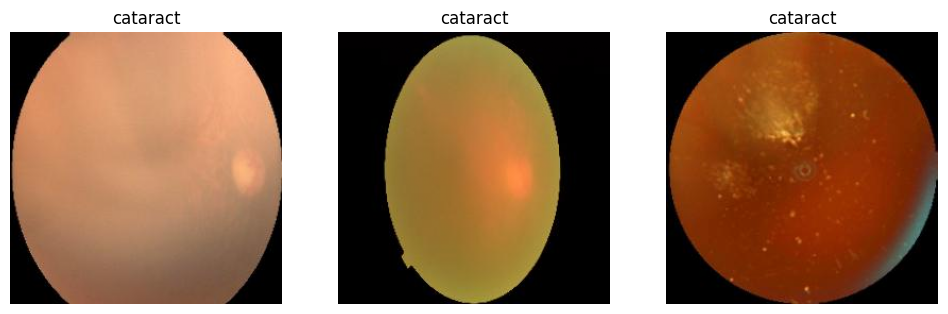

In [ ]:
plot_image(0)

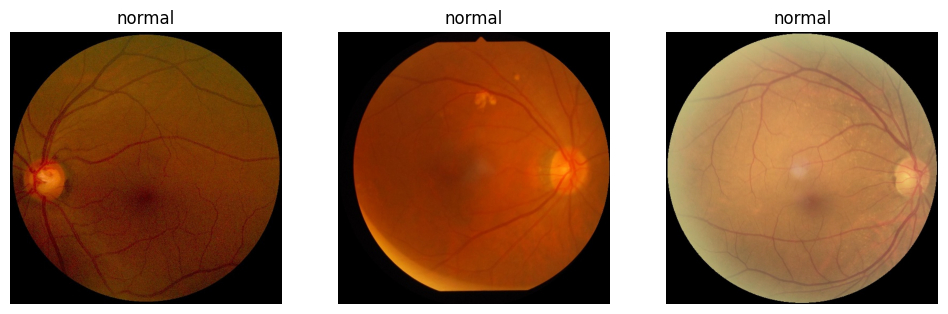

In [ ]:
plot_image(1)

In [ ]:
df['disease_type'] = df['disease_type'].map({0:'cataract',1:'normal'})

In [ ]:
df.disease_type.value_counts()

disease_type
normal      1074
cataract    1038
Name: count, dtype: int64

In [ ]:
df1=df.sample(frac=1).reset_index(drop=True)

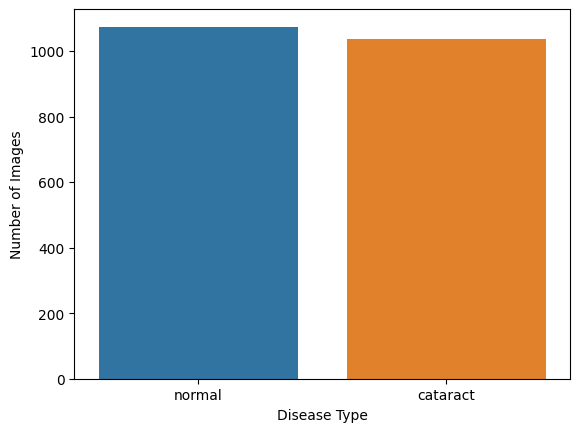

In [ ]:
sns.countplot(x='disease_type', data=df1)
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.savefig('countplot.png')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

# Data Training& Testing

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2,rescale=1./255.)


In [ ]:
# Data generators for training
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 1690 validated image filenames belonging to 2 classes.


In [ ]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 422 validated image filenames belonging to 2 classes.


# Building The Model

## Model1: VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

vgg_model = Sequential()
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in vgg_base.layers:
    layer.trainable = False

vgg_model.add(vgg_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(2, activation="sigmoid"))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.summary()


80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


## Model 2: ResNet50


In [ ]:
from tensorflow.keras.applications import ResNet50

resnet_model = Sequential()
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.add(resnet_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(2, activation="sigmoid"))
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

resnet_model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


## Model 3: InceptionV3


In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_model = Sequential()
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in inception_base.layers:
    layer.trainable = False

inception_model.add(inception_base)
inception_model.add(Flatten())
inception_model.add(Dense(2, activation="sigmoid"))
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

inception_model.summary()


87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102402    
                                                                 
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


# Train the Models


## Train VGG19


In [ ]:
vgg_history = vgg_model.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)


Epoch 1/15
53/53 [==============================] - 35s 563ms/step - loss: 0.3381 - accuracy: 0.8538 - val_loss: 114.2628 - val_accuracy: 0.9242
Epoch 2/15
53/53 [==============================] - 17s 330ms/step - loss: 0.1537 - accuracy: 0.9444 - val_loss: 125.4298 - val_accuracy: 0.9289
Epoch 3/15
53/53 [==============================] - 18s 333ms/step - loss: 0.1272 - accuracy: 0.9544 - val_loss: 41.1117 - val_accuracy: 0.9502
Epoch 4/15
53/53 [==============================] - 18s 347ms/step - loss: 0.1237 - accuracy: 0.9544 - val_loss: 44.2832 - val_accuracy: 0.9502
Epoch 5/15
53/53 [==============================] - 18s 332ms/step - loss: 0.1025 - accuracy: 0.9621 - val_loss: 34.7319 - val_accuracy: 0.9384
Epoch 6/15
53/53 [==============================] - 17s 330ms/step - loss: 0.0898 - accuracy: 0.9680 - val_loss: 27.2646 - val_accuracy: 0.9313
Epoch 7/15
53/53 [==============================] - 18s 338ms/step - loss: 0.0809 - accuracy: 0.9740 - val_loss: 36.6286 - val_accurac

## Train ResNet50

In [ ]:
resnet_history = resnet_model.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)


Epoch 1/15
53/53 [==============================] - 23s 363ms/step - loss: 1.0882 - accuracy: 0.6024 - val_loss: 0.6279 - val_accuracy: 0.5379
Epoch 2/15
53/53 [==============================] - 18s 341ms/step - loss: 0.5562 - accuracy: 0.7254 - val_loss: 0.5701 - val_accuracy: 0.6991
Epoch 3/15
53/53 [==============================] - 17s 313ms/step - loss: 0.5479 - accuracy: 0.7000 - val_loss: 0.5433 - val_accuracy: 0.6967
Epoch 4/15
53/53 [==============================] - 17s 330ms/step - loss: 0.5324 - accuracy: 0.7142 - val_loss: 0.5684 - val_accuracy: 0.7464
Epoch 5/15
53/53 [==============================] - 17s 321ms/step - loss: 0.5413 - accuracy: 0.7331 - val_loss: 0.5382 - val_accuracy: 0.7109
Epoch 6/15
53/53 [==============================] - 17s 326ms/step - loss: 0.4746 - accuracy: 0.7669 - val_loss: 0.4644 - val_accuracy: 0.7796
Epoch 7/15
53/53 [==============================] - 17s 314ms/step - loss: 0.4103 - accuracy: 0.8030 - val_loss: 0.4982 - val_accuracy: 0.7275

## Train InceptionV3

In [ ]:
inception_history = inception_model.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)


Epoch 1/15
53/53 [==============================] - 26s 380ms/step - loss: 0.6906 - accuracy: 0.9154 - val_loss: 0.2509 - val_accuracy: 0.9526
Epoch 2/15
53/53 [==============================] - 17s 326ms/step - loss: 0.1370 - accuracy: 0.9675 - val_loss: 0.1756 - val_accuracy: 0.9550
Epoch 3/15
53/53 [==============================] - 17s 326ms/step - loss: 0.0592 - accuracy: 0.9899 - val_loss: 0.2777 - val_accuracy: 0.9526
Epoch 4/15
53/53 [==============================] - 18s 336ms/step - loss: 0.0455 - accuracy: 0.9876 - val_loss: 0.1791 - val_accuracy: 0.9597
Epoch 5/15
53/53 [==============================] - 17s 330ms/step - loss: 0.0097 - accuracy: 0.9994 - val_loss: 0.1978 - val_accuracy: 0.9645
Epoch 6/15
53/53 [==============================] - 17s 310ms/step - loss: 0.0120 - accuracy: 0.9982 - val_loss: 0.1421 - val_accuracy: 0.9668
Epoch 7/15
53/53 [==============================] - 17s 327ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1516 - val_accuracy: 0.9621

# Compare the Models

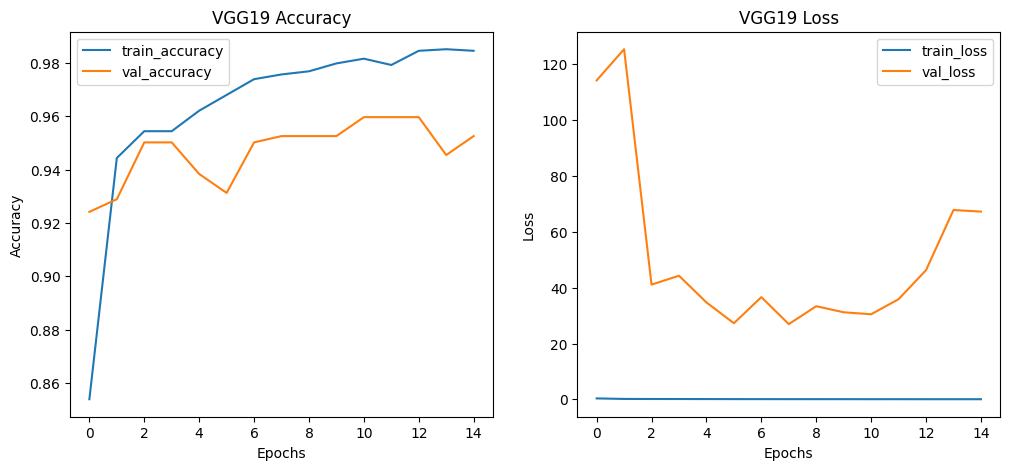

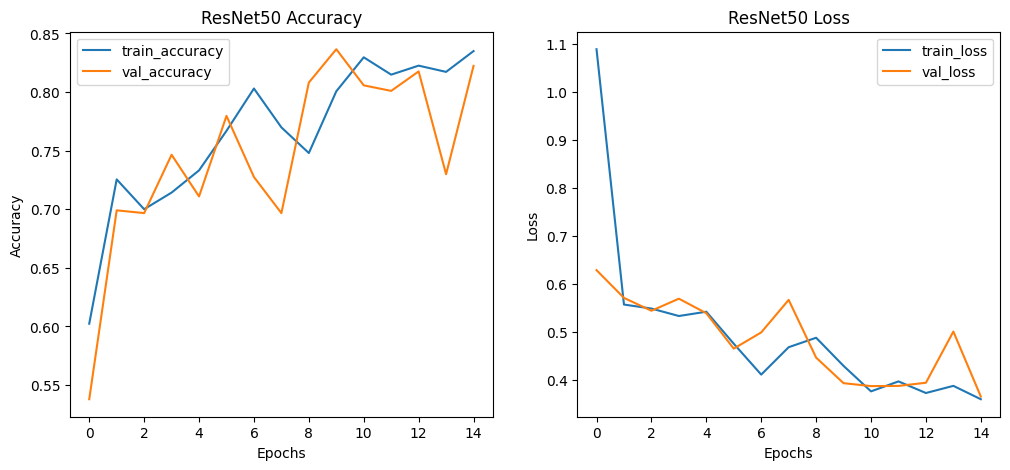

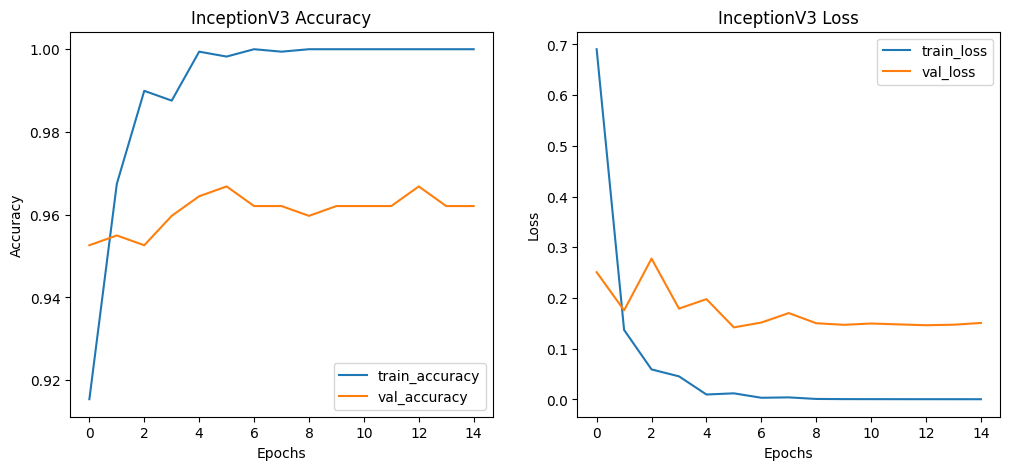

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(vgg_history, 'VGG19')
plot_history(resnet_history, 'ResNet50')
plot_history(inception_history, 'InceptionV3')


## Evaluate the final accuracy

In [ ]:
vgg_eval = vgg_model.evaluate(valid_data)
resnet_eval = resnet_model.evaluate(valid_data)
inception_eval = inception_model.evaluate(valid_data)

print(f"VGG19 Validation Accuracy: {vgg_eval[1]:.4f}")
print(f"ResNet50 Validation Accuracy: {resnet_eval[1]:.4f}")
print(f"InceptionV3 Validation Accuracy: {inception_eval[1]:.4f}")


14/14 [==============================] - 4s 254ms/step - loss: 0.1508 - accuracy: 0.9621
VGG19 Validation Accuracy: 0.9526
ResNet50 Validation Accuracy: 0.8223
InceptionV3 Validation Accuracy: 0.9621


## Generate a Classification Report


In [ ]:
from sklearn.metrics import classification_report

def classification_report_for_model(model, valid_data):
    valid_data.reset()
    predictions = model.predict(valid_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = valid_data.classes
    print(classification_report(y_true, y_pred, target_names=list(valid_data.class_indices.keys())))


print("classification report for VGG19 model")
classification_report_for_model(vgg_model, valid_data)

print("---------------------------------------------------")
print("classification report for ResNet50 model")
classification_report_for_model(resnet_model, valid_data)

print("---------------------------------------------------")
print("classification report for InceptionV3 model")
classification_report_for_model(inception_model, valid_data)


classification report for VGG19 model
14/14 [==============================] - 4s 244ms/step
              precision    recall  f1-score   support

    cataract       0.93      0.98      0.95       219
      normal       0.98      0.92      0.95       203

    accuracy                           0.95       422
   macro avg       0.95      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422

---------------------------------------------------
classification report for ResNet50 model
14/14 [==============================] - 4s 246ms/step
              precision    recall  f1-score   support

    cataract       0.93      0.71      0.81       219
      normal       0.75      0.95      0.84       203

    accuracy                           0.82       422
   macro avg       0.84      0.83      0.82       422
weighted avg       0.85      0.82      0.82       422

---------------------------------------------------
classification report for InceptionV3 model
14/14 [==

**VGG19** performs the best.